In [67]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import pandas as pd

In [68]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [69]:
! kaggle datasets download -d sumanthvrao/daily-climate-time-series-data
! unzip daily-climate-time-series-data.zip

daily-climate-time-series-data.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  daily-climate-time-series-data.zip
replace DailyDelhiClimateTest.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [70]:
train_dataset = pd.read_csv('DailyDelhiClimateTrain.csv')

In [71]:
train_dataset.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [72]:
train_dataset.corr()

,meantemp,humidity,wind_speed,meanpressure
meantemp,1.000000,-0.571951,0.306468,-0.038818
humidity,-0.571951,1.000000,-0.373972,0.001734
wind_speed,0.306468,-0.373972,1.000000,-0.020670
meanpressure,-0.038818,0.001734,-0.020670,1.000000


In [73]:
train_dataset.isnull().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [74]:
num_train = int(0.8*(len(train_dataset['meantemp'])))
xtrain, xval = train_dataset['meantemp'][:num_train], train_dataset['meantemp'][num_train:]

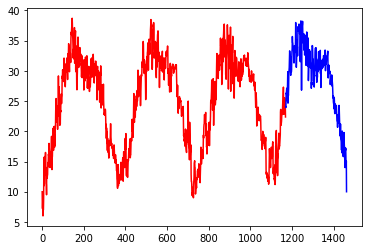

In [75]:
plt.plot(xtrain, color='red')
plt.plot(xval, color='blue')

In [76]:
window_size = 32
batch_size = 32
shuffle_buffer_size = 500

In [77]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [78]:
dataset = windowed_dataset(xtrain, window_size, batch_size, shuffle_buffer_size)

In [79]:
type(dataset)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [80]:
for windows in dataset.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 32)
shape of second element: (32,)


In [81]:
val_set = windowed_dataset(xval, window_size, batch_size, shuffle_buffer_size)

In [82]:
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
  layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  layers.Bidirectional(tf.keras.layers.LSTM(90, return_sequences=True)),
  layers.Bidirectional(tf.keras.layers.LSTM(90)),
  layers.Dense(1),
  layers.Lambda(lambda x: x * 100.0)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 180)        66240     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 180)              195120    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 181       
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 261,541
Trainable params: 261,541
Non-trai

Epoch 1/100
36/36 [==============================] - 9s 110ms/step - loss: 47.3537 - lr: 1.0000e-08
Epoch 2/100
36/36 [==============================] - 5s 127ms/step - loss: 44.4669 - lr: 1.1220e-08
Epoch 3/100
36/36 [==============================] - 5s 123ms/step - loss: 40.9810 - lr: 1.2589e-08
Epoch 4/100
36/36 [==============================] - 4s 113ms/step - loss: 36.9353 - lr: 1.4125e-08
Epoch 5/100
36/36 [==============================] - 3s 78ms/step - loss: 32.0581 - lr: 1.5849e-08
Epoch 6/100
36/36 [==============================] - 2s 65ms/step - loss: 26.3088 - lr: 1.7783e-08
Epoch 7/100
36/36 [==============================] - 2s 65ms/step - loss: 20.1531 - lr: 1.9953e-08
Epoch 8/100
36/36 [==============================] - 2s 66ms/step - loss: 13.7595 - lr: 2.2387e-08
Epoch 9/100
36/36 [==============================] - 2s 65ms/step - loss: 9.5549 - lr: 2.5119e-08
Epoch 10/100
36/36 [==============================] - 2s 65ms/step - loss: 8.6601 - lr: 2.8184e-08
Epoch 1

(1e-08, 0.001, 0.0, 30.0)

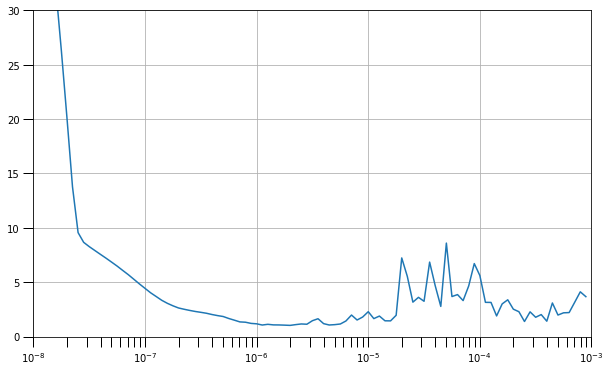

In [83]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 30])

In [85]:
learning_rate = 5e-6

model.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam',
              metrics=["mae", "mse"])

history = model.fit(dataset, epochs=100, validation_data=val_set)

Epoch 1/100
36/36 [==============================] - 9s 103ms/step - loss: 0.8691 - mae: 1.2796 - mse: 2.7955 - val_loss: 1.0649 - val_mae: 1.5042 - val_mse: 3.4956
Epoch 2/100
36/36 [==============================] - 3s 69ms/step - loss: 0.8449 - mae: 1.2540 - mse: 2.7210 - val_loss: 0.8923 - val_mae: 1.3035 - val_mse: 2.8913
Epoch 3/100
36/36 [==============================] - 3s 70ms/step - loss: 0.8194 - mae: 1.2239 - mse: 2.6216 - val_loss: 0.8622 - val_mae: 1.2727 - val_mse: 2.8193
Epoch 4/100
36/36 [==============================] - 3s 71ms/step - loss: 0.8514 - mae: 1.2616 - mse: 2.7693 - val_loss: 0.8293 - val_mae: 1.2327 - val_mse: 2.6699
Epoch 5/100
36/36 [==============================] - 3s 72ms/step - loss: 0.8093 - mae: 1.2172 - mse: 2.5939 - val_loss: 0.8480 - val_mae: 1.2526 - val_mse: 2.6988
Epoch 6/100
36/36 [==============================] - 3s 70ms/step - loss: 0.8208 - mae: 1.2261 - mse: 2.6583 - val_loss: 0.8334 - val_mae: 1.2377 - val_mse: 2.6504
Epoch 7/100
36/

In [86]:
def model_forecast(model, series, window_size, batch_size):

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

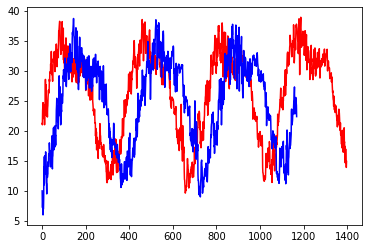

In [87]:
# Reduce the original series
forecast_series = train_dataset['meantemp'][window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plt.plot(results, color='red')
plt.plot(xtrain.values, color='blue')

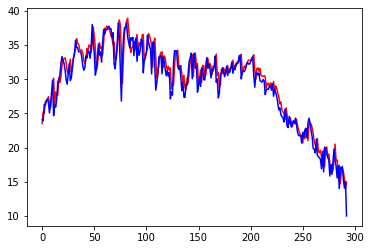

In [88]:
forecast_series = train_dataset['meantemp'][num_train-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plt.plot(results, color='red')
plt.plot(xval.values, color='blue')

In [89]:
test_dataset = pd.read_csv('DailyDelhiClimateTest.csv')
xtest = test_dataset['meantemp']

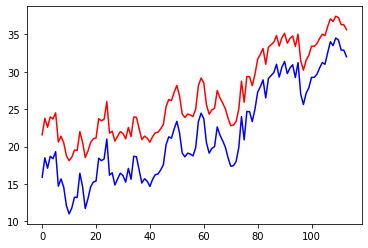

In [99]:
forecast_series = test_dataset['meantemp']

# Use helper function to generate predictions
forecast = model_forecast(model=model, series=forecast_series, window_size=1, batch_size=batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plt.plot(results, color='red')
plt.plot(xtest, color='blue')

In [100]:
print(tf.keras.metrics.mean_squared_error(xtest, results).numpy())
print(tf.keras.metrics.mean_absolute_error(xtest, results).numpy())

25.547972
4.982974


In [101]:
def plot_graphs(history, string):
  plt.plot(history.history[string][10:])
  plt.plot(history.history['val_'+string][10:])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [102]:
history.history.keys()

dict_keys(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'])

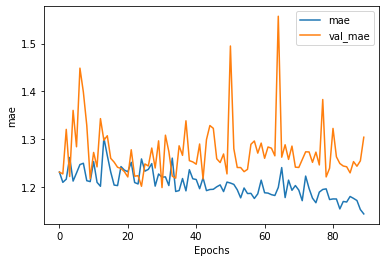

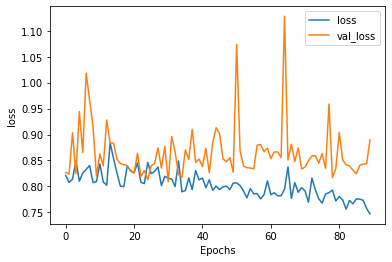

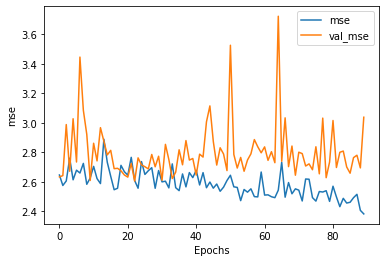

In [103]:
plot_graphs(history, 'mae')
plot_graphs(history, 'loss')
plot_graphs(history, 'mse')